In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import time
import numpy as np
from sklearn.inspection import permutation_importance
import warnings

from collections import OrderedDict
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano as thno
import theano.tensor as T

from scipy import integrate
from scipy.optimize import fmin_powell

print(f"Running on PyMC3 v{pm.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.5


In [70]:
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from sklearn.metrics import confusion_matrix

In [2]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "educ",
        "marital",
        "occupation",
        "relationship",
        "race",
        "sex",
        "captial-gain",
        "capital-loss",
        "hours",
        "country",
        "income",
    ],
)
raw_data.head(10)

,age,workclass,fnlwgt,education,educ,marital,occupation,relationship,race,sex,captial-gain,capital-loss,hours,country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [3]:
data = raw_data[~pd.isnull(raw_data["income"])]

In [4]:
data["age"] = data["age"] / 10.0
data["age2"] = np.square(data["age"])
# data["hours"] = data["hours"] / 10.0
# data["gains"] = (data["captial-gain"]- data["capital-loss"])/ 100.0
data["income"]=np.where(data["income"]==" >50K",1,0)
data = data[["age", "educ", "hours","age2","income"]]

In [5]:
data.head()

,age,educ,hours,age2,income
0,3.9,13,40,15.21,0
1,5.0,13,13,25.00,0
2,3.8,9,40,14.44,0
3,5.3,7,40,28.09,0
4,2.8,13,40,7.84,0


In [6]:
income=data["income"]
data = data.drop(['income'], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, income, stratify=income, random_state=42)

In [8]:
data_tensor = thno.shared(X_train.values.astype('float64'))
target_tensor = thno.shared(y_train.values.astype('int64'))

In [9]:
n_parameters=4

In [10]:
with pm.Model() as complete_model:
    betas = pm.Normal('betas', 0, sigma=10, shape=n_parameters)
    logistic_coef = [betas[i] * data_tensor.transpose()[i] for i in range(n_parameters)] 
    
    likelihood = pm.math.sigmoid(logistic_coef)
    y = pm.Bernoulli('y', likelihood, observed=target_tensor)

with complete_model:
    complete_trace = pm.sample(5000, step=pm.Metropolis())
    complete_burned_trace = complete_trace[1000:]  

C:\ProgramData\Anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [betas]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 375 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [23]:
#compute the average probability of predicting 1. 
# y_score = np.mean(complete_burned_trace[likelihood], axis=0)
# complete_burned_trace[likelihood[10:]]

In [21]:
y.eval()
y.eval().sum()

5881

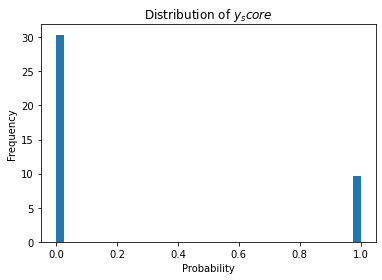

In [22]:
# figsize(12.5,4)
plt.hist(y.eval(), bins=40, density=True)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of $y_score$')
plt.show()

In [69]:
y_pred0=y.eval()

In [71]:
confusion_matrix(y_train, y_pred0)

array([[18539,     0],
       [    0,  5881]], dtype=int64)

In [73]:
target_pred = thno.shared(y_test.values.astype('int64'))
with complete_model:
#     y_pred = pm.Bernoulli('y', likelihood, observed=target_pred)
    post_pred = pm.sample_posterior_predictive(complete_burned_trace)

In [ ]:
# post_pred

In [78]:
post_pred.keys()

dict_keys(['y'])

In [79]:
sample_post_pred = post_pred['y']

In [82]:
def decorate_rate(ylabel='Likelihood'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    legend()
    
import seaborn as sns

def plot_hist(sample, **options):
    """Plot a histogram of goals.
    
    sample: sequence of values
    """
    sns.histplot(sample, stat='probability', discrete=True,
                 alpha=0.5, **options)

In [84]:
# plot_hist(sample_post_pred, label='posterior pred') # ValueError: Must pass 2-d input. shape=(16000, 4, 24420)
# decorate_goals()

## Unpooled Model(s)

In [63]:
data2 = raw_data[~pd.isnull(raw_data["income"])]
# data2 = data2[data2.country!=" ?"]

In [64]:
g7plus=[" Germany"," Canada"," England"," Italy"," France"," Ireland"," Scotland"]

In [65]:
data2["country"]=np.where(data2["country"]==" United-States",1,data2["country"])
data2["country"]=np.where(data2["country"]==" ?",0,data2["country"])
data2["country"]=np.where(data2["country"].isin(g7plus),2,data2["country"])
data2["country"]=np.where(~data2["country"].isin([0,1,2]),3,data2["country"])

In [66]:
data2["country"].value_counts()

1    29170
3     2322
0      583
2      486
Name: country, dtype: int64

In [67]:
data2["age"] = data2["age"] / 10.0
data2["age2"] = np.square(data2["age"])
data2["income"]=np.where(data2["income"]==" >50K",1,0)
data2 = data2[["age", "educ", "hours","age2","income","country"]]
data2.head()

,age,educ,hours,age2,income,country
0,3.9,13,40,15.21,0,1
1,5.0,13,13,25.00,0,1
2,3.8,9,40,14.44,0,1
3,5.3,7,40,28.09,0,1
4,2.8,13,40,7.84,0,3


In [85]:
income=data2["income"]
data2 = data2.drop(['income'], axis=1)

In [86]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, income, stratify=income, random_state=42)

In [88]:
geo_train2 = X_train2["country"]
X_train2= X_train2.drop(["country"], axis=1)

In [90]:
data_tensor2 = thno.shared(X_train2.values.astype('float64'))
target_tensor2 = thno.shared(y_train2.values.astype('int64'))
geo_region_tensor2 = thno.shared(geo_train2.values.astype('int64'))

In [92]:
n_regions=4

In [95]:
with pm.Model() as unpooled_model:    
    betas_T = pm.Normal('betas', mu=0, sigma=100, shape=(n_regions,n_parameters))
    betas2 = T.transpose(betas_T)

    geo_region_cast2 = T.cast(geo_region_tensor2, dtype='int64')
    logistic_coeff2 = [betas2[i, geo_region_cast2] * data_tensor2.transpose()[i] for i in range(n_parameters)]
    likelihood2 = pm.math.sigmoid(logistic_coeff2)
        
    # Data likelihood    
    y2 = pm.Bernoulli('y2', likelihood2, observed=target_tensor2)

In [100]:
with unpooled_model:
    unpooled_trace = pm.sample(1000,cores=2, step=pm.Metropolis())
    unpooled_burned_trace = unpooled_trace[200:]
    
# pm.traceplot(unpooled_burned_trace)
# pm.summary(unpooled_burned_trace)

C:\ProgramData\Anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [betas]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [101]:
unpooled_trace

<MultiTrace: 2 chains, 1000 iterations, 1 variables>

In [102]:
unpooled_model

In [106]:
with unpooled_model:
    print(pm.summary(unpooled_burned_trace))

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0] -0.099  0.014  -0.120   -0.081      0.009    0.007       3.0   
betas[0, 1] -0.013  0.033  -0.079    0.027      0.020    0.016       3.0   
betas[0, 2] -0.023  0.006  -0.035   -0.012      0.002    0.002      11.0   
betas[0, 3] -0.021  0.012  -0.039   -0.008      0.007    0.006       3.0   
betas[1, 0] -0.223  0.007  -0.237   -0.211      0.003    0.002       5.0   
betas[1, 1] -0.089  0.004  -0.095   -0.082      0.001    0.001      21.0   
betas[1, 2] -0.022  0.001  -0.025   -0.021      0.000    0.000      33.0   
betas[1, 3] -0.035  0.002  -0.038   -0.031      0.000    0.000      51.0   
betas[2, 0] -0.109  0.125  -0.243    0.024      0.087    0.074       3.0   
betas[2, 1] -0.076  0.030  -0.118   -0.031      0.020    0.017       2.0   
betas[2, 2] -0.011  0.006  -0.023   -0.003      0.002    0.002      14.0   
betas[2, 3] -0.013  0.007  -0.031   -0.003      0.002    0.001      14.0   
betas[3, 0] 

--> 4 Models (0,1,2,3)

## Hierarchical Bayes Model

In [111]:
with pm.Model() as hierarchical_model:    
    mu = pm.Normal('mu', .0, sigma=10, shape=n_parameters)
    sigma = pm.HalfNormal('sigma', sigma=5., shape=n_parameters)
    
    betas_T_3 = pm.Normal('betas', mu=mu, sigma=sigma, shape=(n_regions,n_parameters))
    betas3 = T.transpose(betas_T_3)
    
    geo_region_cast3 = T.cast(geo_region_tensor2, dtype='int64')
    logistic_coeff3 = [betas3[i, geo_region_cast3] * data_tensor2.transpose()[i] for i in range(n_parameters)]
    likelihood3 = pm.math.sigmoid(logistic_coeff3)

    # Data likelihood    
    y3 = pm.Bernoulli('y3', likelihood3, observed=target_tensor2)
    
with hierarchical_model:
    unpooled_trace = pm.sample(200)
    unpooled_burned_trace = unpooled_trace[50:]  #runs too long